In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,Activation,BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from IPython.display import clear_output,FileLink

clear_output()

In [2]:
from keras.backend import tensorflow_backend
tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Data Acquisition

In [3]:
train=pd.read_csv(r'../input/train.csv')
test=pd.read_csv(r'../input/test.csv')

In [4]:
data=train.iloc[:,1:].values
data=data.reshape(-1,28,28,1)/255

In [5]:
labels=pd.get_dummies(train.iloc[:,0]).values

# Data Visualization:

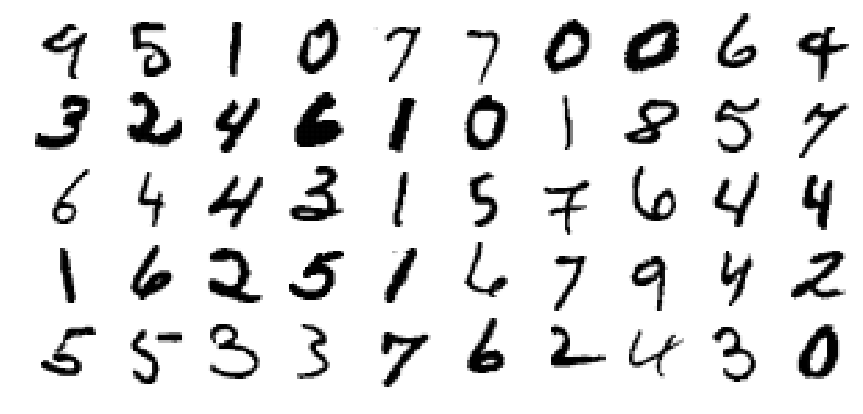

In [6]:
fig,ax=plt.subplots(5,10)
for i in range(5):
    for j in range(10):
        ax[i][j].imshow(data[np.random.randint(0,data.shape[0]),:,:,0],cmap=plt.cm.binary)
        ax[i][j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)        
fig.set_figwidth(15)
fig.set_figheight(7)
fig.show()

# Splitting data into Training & Validation Sets

In [7]:
X_train,X_val,y_train,y_val=train_test_split(data,labels,test_size=0.33,random_state=42)

# Data Augmentation:

In [8]:
aug_data=ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

## Example:

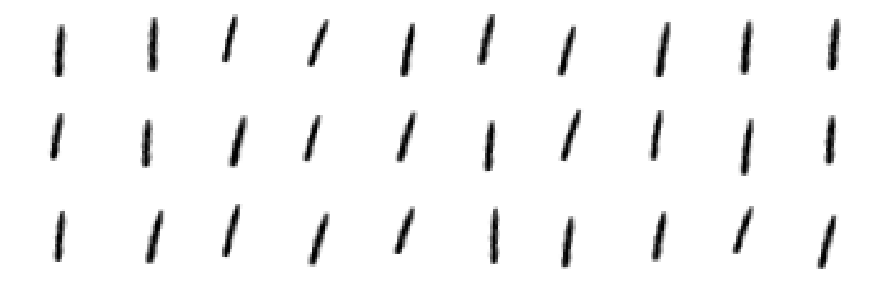

In [9]:
fig,ax=plt.subplots(3,10)
idx=np.random.randint(0,data.shape[0])
for i in range(3):
    for j in range(10):
        ax[i][j].axis('off')
        X,y=aug_data.flow(data[idx].reshape(-1,28,28,1),labels[idx].reshape(1,10)).next()
        ax[i][j].imshow(X.reshape(28,28),cmap=plt.cm.binary)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.show()

In [10]:
generator=aug_data.flow(X_train,y_train,batch_size=64)

# Model Creation

In [11]:
def create_model():
    model=Sequential()

    model.add(Conv2D(32,(3,3),input_shape=(28,28,1),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),strides=(2,2),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),strides=(2,2),padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128,(4,4),activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))

    model.add(Dropout(0.4))
    model.add(Dense(10,activation='softmax'))

    model.compile(optimizer='adam',loss=categorical_crossentropy,metrics=['accuracy'])
    
    return model

In [12]:
model=create_model()

# Fitting model on Training data

In [13]:
history=model.fit_generator(generator,epochs=50,validation_data=(X_val,y_val),steps_per_epoch=data.shape[0]//64)

Epoch 1/50
656/656 [==============================] - 19s 29ms/step - loss: 0.4323 - accuracy: 0.8634 - val_loss: 0.0567 - val_accuracy: 0.9823
Epoch 2/50
656/656 [==============================] - 15s 23ms/step - loss: 0.1241 - accuracy: 0.9628 - val_loss: 0.0485 - val_accuracy: 0.9850
Epoch 3/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0952 - accuracy: 0.9724 - val_loss: 0.0387 - val_accuracy: 0.9885
Epoch 4/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0815 - accuracy: 0.9762 - val_loss: 0.0326 - val_accuracy: 0.9903
Epoch 5/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0709 - accuracy: 0.9792 - val_loss: 0.0466 - val_accuracy: 0.9865
Epoch 6/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0700 - accuracy: 0.9800 - val_loss: 0.0322 - val_accuracy: 0.9902
Epoch 7/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0601 - accuracy: 0.9819 - val_loss: 0.0266 - val_accuracy:

# Visualizing Performance of the model:

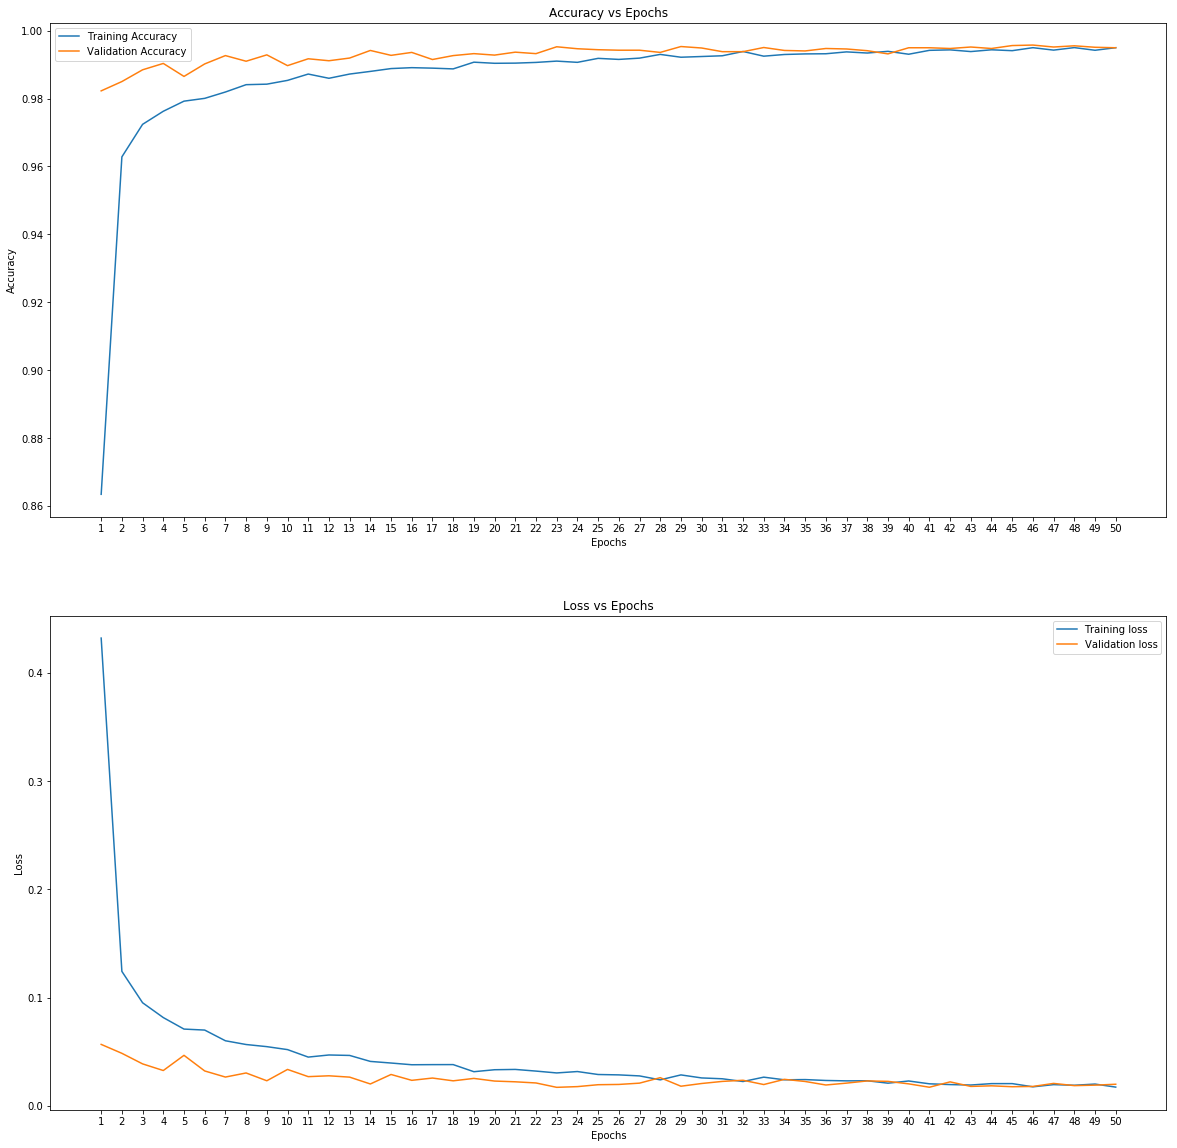

In [14]:
fig,(acc,loss)=plt.subplots(2,1)


acc.set_title('Accuracy vs Epochs')
acc.plot(np.arange(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='Training Accuracy')
acc.plot(np.arange(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'],label='Validation Accuracy')
acc.set_xlabel('Epochs')
acc.set_ylabel('Accuracy')
acc.set_xticks(np.arange(1,len(history.history['accuracy'])+1))
acc.legend(loc='best')

loss.set_title('Loss vs Epochs')
loss.plot(np.arange(1,len(history.history['loss'])+1),history.history['loss'],label='Training loss')
loss.plot(np.arange(1,len(history.history['val_loss'])+1),history.history['val_loss'],label='Validation loss')
loss.set_xlabel('Epochs')
loss.set_ylabel('Loss')
loss.set_xticks(np.arange(1,len(history.history['loss'])+1))
loss.legend(loc='best')

fig.set_figheight(20)
fig.set_figwidth(20)
fig.show()

# Fitting Model on Total data

In [15]:
generator=aug_data.flow(data,labels,batch_size=64)

In [16]:
model=create_model()

In [17]:
history=model.fit_generator(generator,epochs=50,validation_data=(X_val,y_val),steps_per_epoch=data.shape[0]//64)

Epoch 1/50
656/656 [==============================] - 17s 25ms/step - loss: 0.4363 - accuracy: 0.8642 - val_loss: 0.0623 - val_accuracy: 0.9809
Epoch 2/50
656/656 [==============================] - 15s 24ms/step - loss: 0.1293 - accuracy: 0.9624 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 3/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0990 - accuracy: 0.9715 - val_loss: 0.0427 - val_accuracy: 0.9868
Epoch 4/50
656/656 [==============================] - 16s 24ms/step - loss: 0.0852 - accuracy: 0.9753 - val_loss: 0.0287 - val_accuracy: 0.9911
Epoch 5/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0746 - accuracy: 0.9779 - val_loss: 0.0281 - val_accuracy: 0.9906
Epoch 6/50
656/656 [==============================] - 16s 25ms/step - loss: 0.0686 - accuracy: 0.9805 - val_loss: 0.0232 - val_accuracy: 0.9927
Epoch 7/50
656/656 [==============================] - 15s 23ms/step - loss: 0.0656 - accuracy: 0.9810 - val_loss: 0.0198 - val_accuracy:

# Model Performance

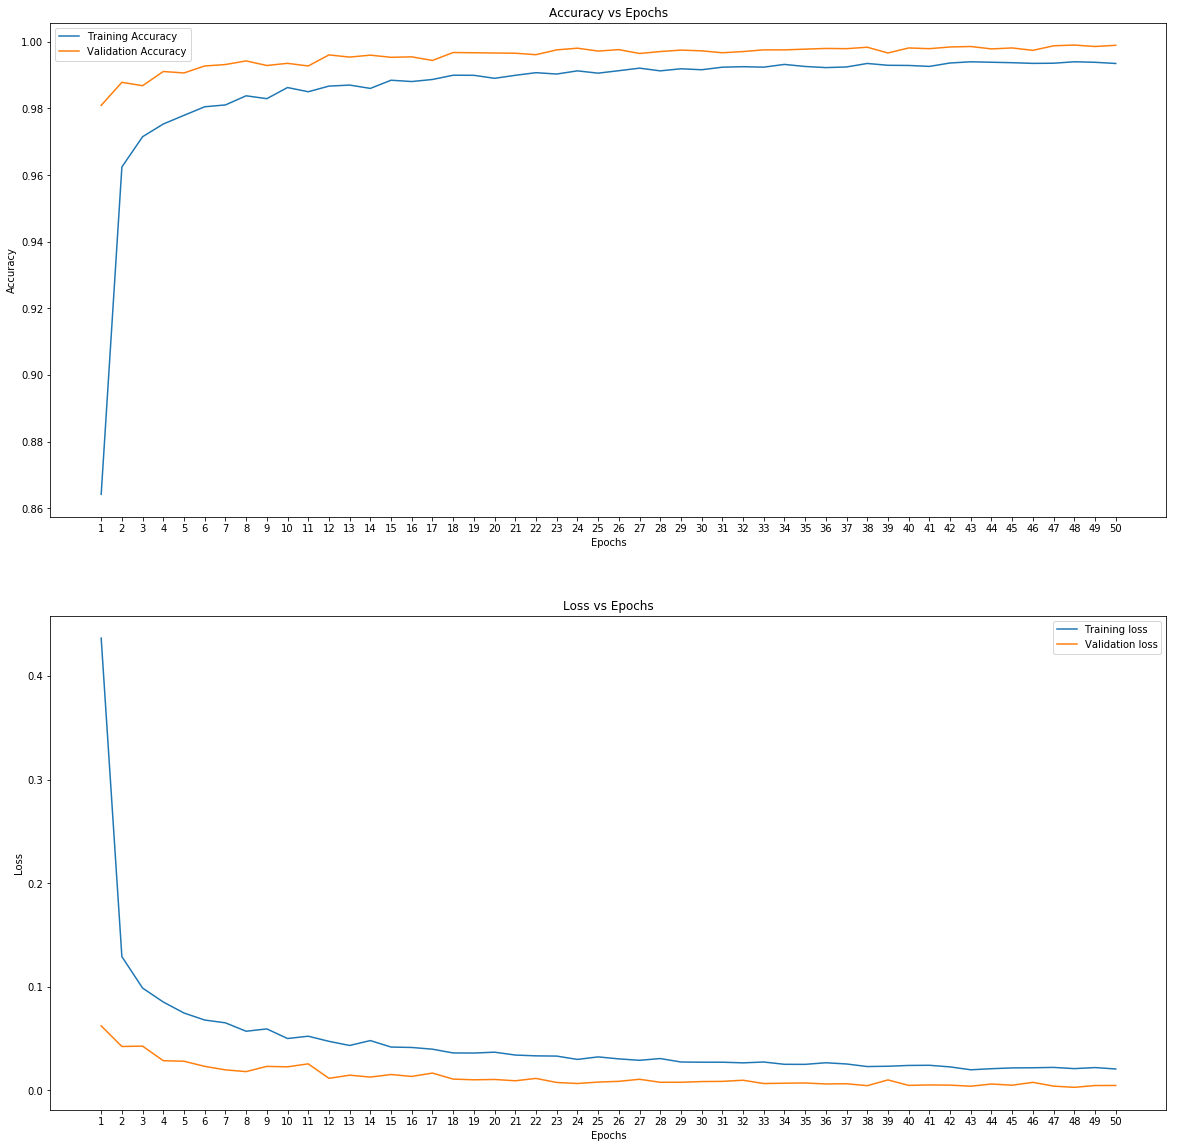

In [18]:
fig,(acc,loss)=plt.subplots(2,1)


acc.set_title('Accuracy vs Epochs')
acc.plot(np.arange(1,len(history.history['accuracy'])+1),history.history['accuracy'],label='Training Accuracy')
acc.plot(np.arange(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'],label='Validation Accuracy')
acc.set_xlabel('Epochs')
acc.set_ylabel('Accuracy')
acc.set_xticks(np.arange(1,len(history.history['accuracy'])+1))
acc.legend(loc='best')

loss.set_title('Loss vs Epochs')
loss.plot(np.arange(1,len(history.history['loss'])+1),history.history['loss'],label='Training loss')
loss.plot(np.arange(1,len(history.history['val_loss'])+1),history.history['val_loss'],label='Validation loss')
loss.set_xlabel('Epochs')
loss.set_ylabel('Loss')
loss.set_xticks(np.arange(1,len(history.history['loss'])+1))
loss.legend(loc='best')

fig.set_figheight(20)
fig.set_figwidth(20)
fig.show()

# Generating predictions for Test set

In [19]:
x_test=test.values.reshape(-1,28,28,1)/255

In [20]:
pred=np.argmax(model.predict(x=x_test),1)

In [21]:
output=np.concatenate((np.arange(1,test.shape[0]+1).reshape(-1,1),pred.reshape(-1,1)),axis=1)

# Creating Submission file

In [22]:
submission=pd.DataFrame(output,columns=['ImageId','Label'])

In [23]:
submission.to_csv('Submission.csv',index=False)

In [24]:
from IPython.display import FileLink

In [25]:
model.save('model.h5')

# Pre-Trained Model Link

In [26]:
FileLink('model.h5')

/kaggle/working/model.h5